This file is only performed on one day's(1.30) data: 
0. explore the dataset
1. Preprocessing steps: remove data: teacher/bad time/
2. Build the coordinate dataframe for all members of each scene
2. calculate the affinity matrix/f-formations using distance/ distance + orientation per second


KC_O: In COTALK folder, it's the degree wrt to +y axis, converted to orientation (in degrees) of an individual measured with respect to the +x axis here. Value ranges from -180 to +180 degrees.


Please note that the origin of the XY plane is set to be aligned with the left and bottom sides of the classroom boundary (from top view)

In [1]:
import dominant_sets

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import os
from collections import defaultdict, Counter


In [2]:
# Date: 1.30
#3
file_path = "D:\OneDrive - Delft University of Technology\Thesis\DEBBIE_STARFISH_2223\Version 3_ Kalman_Fixed_Data + Overlap Filter\Synched_Data_GR0_2to2_ANGLE45\COTALK\DAYCOTALK_013023_COTALK0_22_DEN_072924_V21588968411.CSV" 

df = pd.read_csv(file_path)
df.drop(columns=['VOCCHNCHF_LENAKF']) # vocalization not used
df['TIME'] = pd.to_datetime(df['TIME'])
df['KC_O'] = 90 - df['KC_O']
df['KC_O'] = (df['KC_O'] + 180) % 360 - 180
df.head()

,SUBJECTID,TIME,KC_X,KC_Y,KC_O,VOCCHNCHF_LENAKF
0,DS_STARFISH_2223_27,2023-01-30 09:35:00.800,2.461364,5.732867,-130.791841,0
1,DS_STARFISH_2223_27,2023-01-30 09:35:00.900,2.449277,5.750987,-130.761752,0
2,DS_STARFISH_2223_27,2023-01-30 09:35:01.000,2.437191,5.769106,-130.725334,0
3,DS_STARFISH_2223_27,2023-01-30 09:35:01.100,2.425105,5.787225,-130.681248,0
4,DS_STARFISH_2223_27,2023-01-30 09:35:01.200,2.413018,5.805345,-130.627867,0


I would just consider children for now, rows of teachers/Lab assistants are removed

In [3]:
children_ids = [
    "DS_STARFISH_2223_27", "DS_STARFISH_2223_28", "DS_STARFISH_2223_29",
    "DS_STARFISH_2223_30", "DS_STARFISH_2223_31", "DS_STARFISH_2223_32",
    "DS_STARFISH_2223_33", "DS_STARFISH_2223_41", "DS_STARFISH_2223_42",
    "DS_STARFISH_2223_43", "DS_STARFISH_2223_44", "DS_STARFISH_2223_45",
    "DS_STARFISH_2223_46"
]

teacher_ids = [
    "DS_STARFISH_2223_T1", "DS_STARFISH_2223_T4", "DS_STARFISH_2223_T3",
    "DS_STARFISH_2223_T10", "DS_STARFISH_2223_Lab1", "DS_STARFISH_2223_Lab2"
]


def filter_rows(row):
    if row['SUBJECTID'] in children_ids:
        return True
    elif row['SUBJECTID'] in teacher_ids:
        return False
    return True

df = df[df.apply(filter_rows, axis=1)]

df['SUBJECTID'] = df['SUBJECTID'].str.extract(r'(\d+)$')

all_children = df['SUBJECTID'].unique()
all_children_num = len(all_children)
print("children numbers: ", all_children_num)
all_children

children numbers:  11


array(['27', '28', '29', '30', '31', '32', '33', '41', '44', '45', '46'],
      dtype=object)

Plot all datapoints to make examinations

In [4]:
df['KC_X'].min(), df['KC_X'].max(), df['KC_Y'].min(), df['KC_Y'].max() , df['KC_O'].min(), df['KC_O'].max()

(0.0315460067638536,
 61.96507081841618,
 0.0300607584032039,
 127.68393433261602,
 -179.99960031936303,
 179.9999531801882)

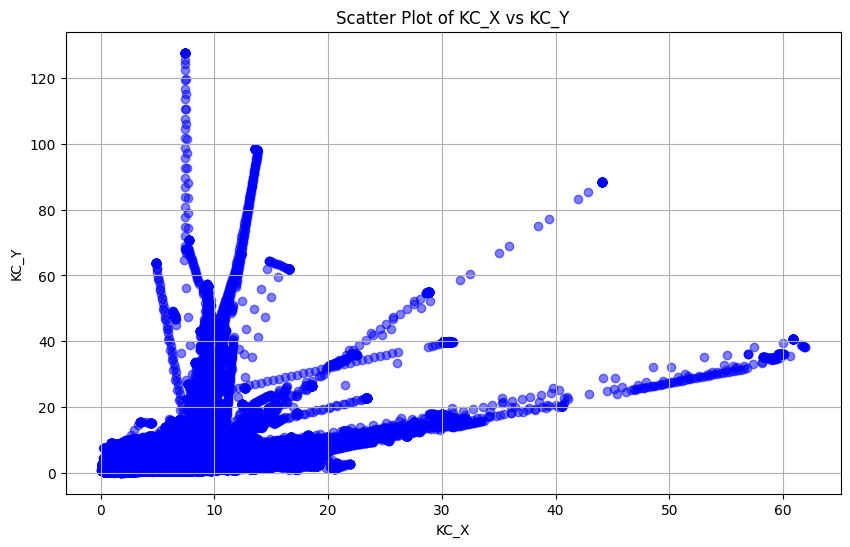

In [5]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['KC_X'], df['KC_Y'], c='blue', alpha=0.5)
plt.title('Scatter Plot of KC_X vs KC_Y')
plt.xlabel('KC_X')
plt.ylabel('KC_Y')
plt.grid(True)
plt.show()

There are quite a lot a points out of classroom range(noisy data)

In [6]:
# # print all rows outside boundries

# filtered_rows = df[(df['KC_X'] > 15) | (df['KC_Y'] > 15)]
# print(filtered_rows)
# filtered_rows.to_csv("Intermediate_results\out_of_boundries.csv", index = False)

In [7]:
# filter bad time: playground time and toilet time accoring to the activity log
def filter_badtime(df):
    filtered_rows = df.copy()
    filtered_rows = filtered_rows[filtered_rows['TIME'] > pd.Timestamp("2023/1/30  9:35:00")] #playground
    filtered_rows = filtered_rows[filtered_rows['TIME'] > pd.Timestamp("2023/1/30  9:47:00")] #toilet
    filtered_rows = filtered_rows[~((filtered_rows['TIME'] >= pd.Timestamp("2023/1/30 10:20:00")) & (filtered_rows['TIME'] <= pd.Timestamp("2023/1/30 10:27:00")))] #toilet
    filtered_rows = filtered_rows[~((filtered_rows['TIME'] >= pd.Timestamp("2023/1/30 10:33:00")) & (filtered_rows['TIME'] <= pd.Timestamp("2023/1/30 10:37:00")))] #toilet
    filtered_rows = filtered_rows[~((filtered_rows['TIME'] >= pd.Timestamp("2023/1/30 11:30:00")) & (filtered_rows['TIME'] <= pd.Timestamp("2023/1/30 11:32:00")))] #toilet
    filtered_rows = filtered_rows[~((filtered_rows['TIME'] >= pd.Timestamp("2023/1/30 11:38:00")) & (filtered_rows['TIME'] <= pd.Timestamp("2023/1/30 11:41:00")))] #toilet
    filtered_rows = filtered_rows[~((filtered_rows['TIME'] >= pd.Timestamp("2023/1/30 11:45:00")) & (filtered_rows['TIME'] < pd.Timestamp("2023/1/30 12:02:00")))] #toilet
    filtered_rows = filtered_rows[~((filtered_rows['TIME'] >= pd.Timestamp("2023/1/30 12:19:00")) & (filtered_rows['TIME'] <= pd.Timestamp("2023/1/30 12:26:00")))] #toilet
    filtered_rows = filtered_rows[filtered_rows['TIME'] < pd.Timestamp("2023/1/30  12:27:00")] #end of the day
    
    return filtered_rows

In [8]:
after_df = filter_badtime(df)
after_df

,SUBJECTID,TIME,KC_X,KC_Y,KC_O,VOCCHNCHF_LENAKF
7193,27,2023-01-30 09:47:00.100,9.640997,3.771259,79.558569,0
7194,27,2023-01-30 09:47:00.200,9.618802,3.820227,69.826781,0
7195,27,2023-01-30 09:47:00.300,9.596607,3.869196,61.870360,0
7196,27,2023-01-30 09:47:00.400,9.574411,3.918164,55.564519,0
7197,27,2023-01-30 09:47:00.500,9.552216,3.967132,50.788085,0
...,...,...,...,...,...,...
1250586,46,2023-01-30 12:26:59.500,12.351901,5.970397,8.831917,0
1250587,46,2023-01-30 12:26:59.600,12.303006,5.952539,-0.415637,0
1250588,46,2023-01-30 12:26:59.700,12.254111,5.934681,-9.343262,0
1250589,46,2023-01-30 12:26:59.800,12.469167,6.043689,-15.471645,0


In [9]:
after_df['KC_X'].min(), after_df['KC_X'].max(), after_df['KC_Y'].min(), after_df['KC_Y'].max() , after_df['KC_O'].min(), after_df['KC_O'].max()

(0.0315460067638536,
 15.108579215090453,
 0.0300607584032039,
 8.326248574531725,
 -179.99918547692437,
 179.9999531801882)

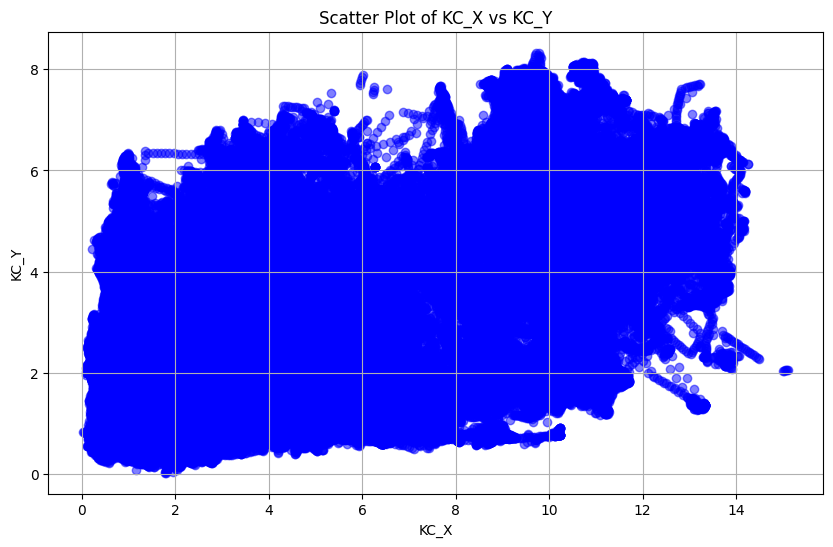

In [10]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(after_df['KC_X'], after_df['KC_Y'], c='blue', alpha=0.5)
plt.title('Scatter Plot of KC_X vs KC_Y')
plt.xlabel('KC_X')
plt.ylabel('KC_Y')
plt.grid(True)
plt.show()


Track the movement of a child

In [11]:
# subject_id = "27"
# time_index_1 = pd.Timestamp("2023/1/30  9:40:47")
# time_index_2 = pd.Timestamp("2023/1/30  9:47:20")
# df_subject = df[(df['SUBJECTID'] == subject_id) & (df['TIME'] >= time_index_1) & (df['TIME'] <= time_index_2)]

# plt.figure(figsize=(10, 6))
# plt.scatter(df_subject['KC_X'], df_subject['KC_Y'], color='blue', alpha=0.7)

# bathroom_x, bathroom_y = 14.073, 4.434
# plt.scatter(bathroom_x, bathroom_y, color='red', marker='x', s=100, label='Bathroom')

# # Annotate the bathroom location
# plt.text(bathroom_x, bathroom_y, 'Bathroom', fontsize=12, ha='right')
    
# plt.title('Line Plot of KC_X vs KC_Y')
# plt.xlabel('KC_X')
# plt.ylabel('KC_Y')
# plt.grid(True)
# plt.show()

In [12]:
def find_time_ranges_outside_classroom(df, classroom_x_range, classroom_y_range):
    # Filter rows where KC_X and KC_Y are outside the classroom range
    df_outside = df[(df['KC_X'] < classroom_x_range[0]) | (df['KC_X'] > classroom_x_range[1]) |
                    (df['KC_Y'] < classroom_y_range[0]) | (df['KC_Y'] > classroom_y_range[1])]
    
    # Group by SUBJECTID
    grouped = df_outside.groupby('SUBJECTID')
    
    if len(df_outside) == 0:
        print("No outside classroom data is found")
    
    # Iterate over each subject
    for subject, group in grouped:
        print(f"\nTime ranges for {subject} outside classroom range:")
        
        # Find continuous time ranges
        time_ranges = []
        start_time = None
        end_time = None
        xy_coords = []

        for i, row in group.iterrows():
            if start_time is None:
                start_time = row['TIME']
                end_time = row['TIME']
                xy_coords = [(row['KC_X'], row['KC_Y'])]
            else:
                if (row['TIME'] - end_time).total_seconds() > 60:  # Assuming 1 second gap as non-continuous
                    time_ranges.append((start_time, end_time, xy_coords))
                    start_time = row['TIME']
                    xy_coords = [(row['KC_X'], row['KC_Y'])]
                else:
                    xy_coords.append((row['KC_X'], row['KC_Y']))
                end_time = row['TIME']
        
        if start_time is not None:
            time_ranges.append((start_time, end_time, xy_coords))
        
        # Print the time ranges and coordinates
        for start_time, end_time, coords in time_ranges:
            print(f"From {start_time} to {end_time}")
            print(f"Coordinates: {coords}")
            if coords:
                x_coords = [x for x, y in coords]
                y_coords = [y for x, y in coords]
                x_range = (min(x_coords), max(x_coords))
                y_range = (min(y_coords), max(y_coords))
                print(f"X range: {x_range}, Y range: {y_range}")

# define classroom dimension
x = 16
y = 16
find_time_ranges_outside_classroom(after_df, [0, x], [0, y])

No outside classroom data is found


In [13]:
# remove outside classroom data, is there is none, they filter_rows == after_df
filtered_rows = after_df[(after_df['KC_X'] <= x) & (after_df['KC_Y'] <= y)]

filtered_rows.to_csv("Intermediate_results\cleaned_df.csv", index = False)
filtered_rows['KC_X'].min(), filtered_rows['KC_X'].max(), filtered_rows['KC_Y'].min(), filtered_rows['KC_Y'].max()

(0.0315460067638536, 15.108579215090453, 0.0300607584032039, 8.326248574531725)

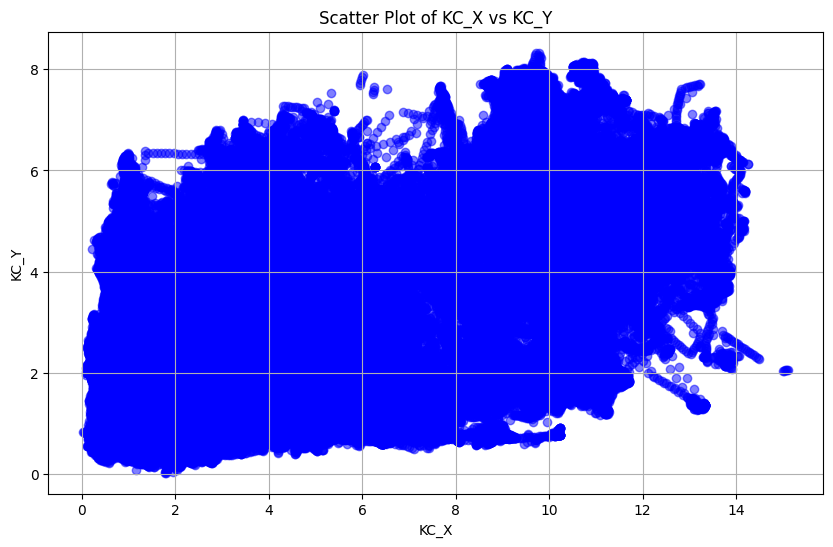

In [14]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_rows['KC_X'], filtered_rows['KC_Y'], c='blue', alpha=0.5)
plt.title('Scatter Plot of KC_X vs KC_Y')
plt.xlabel('KC_X')
plt.ylabel('KC_Y')
plt.grid(True)
plt.show()

Abandoned. Resample the data over each 10s

In [15]:
# time_interval = '10S'

# df['TIME'] = pd.to_datetime(df['TIME'])


# # Set the TIME column as the index
# df.set_index('TIME', inplace=True)

# # Function to average every 10 seconds' KC_X and KC_Y for each subject
# def average_kc(df):
#     # Resample data every 10 seconds and calculate the mean of KC_X and KC_Y
#     return df.resample(time_interval).mean()


# averaged_df = df.groupby('SUBJECTID').apply(average_kc).reset_index()


# averaged_df.to_csv("Intermediate_results\averaged_kc.csv", index=False)
# averaged_df.head()

Lets see how many time intervals each child has

In [16]:
row_counts = filtered_rows.groupby('SUBJECTID').size().reset_index(name='row_count')
row_counts

,SUBJECTID,row_count
0,27,71994
1,28,71994
2,29,71994
3,30,71994
4,31,71994
5,32,71994
6,33,71994
7,41,71994
8,44,71994
9,45,71994


See in each time frame, which the scene looks like, build the coordinates for all members of each scene

In [17]:
unique_times = filtered_rows['TIME'].unique()

# Create a MultiIndex DataFrame
pivot_df = filtered_rows.pivot_table(
    index='TIME', 
    columns='SUBJECTID', 
    values=['KC_X', 'KC_Y', 'KC_O'],
    aggfunc='first'
)


# Flatten the MultiIndex columns
pivot_df.columns = [f'{subject}_{feature}' for feature, subject in pivot_df.columns]

# Sort the columns to get the desired order
sorted_columns = sorted(pivot_df.columns, key=lambda x: (x.split('_')[0], x.split('_')[1]))
pivot_df = pivot_df[sorted_columns]

# Reset index to make TIME a column again
pivot_df.reset_index(inplace=True)

pivot_df.to_csv("Intermediate_results\coordinates_per_scene.csv", index=False)

# Display the first few rows of the DataFrame
print(pivot_df.head())

                     TIME    27_KC_O   27_KC_X   27_KC_Y     28_KC_O  \
0 2023-01-30 09:47:00.100  79.558569  9.640997  3.771259 -128.103914   
1 2023-01-30 09:47:00.200  69.826781  9.618802  3.820227 -128.391350   
2 2023-01-30 09:47:00.300  61.870360  9.596607  3.869196 -127.239567   
3 2023-01-30 09:47:00.400  55.564519  9.574411  3.918164 -126.101620   
4 2023-01-30 09:47:00.500  50.788085  9.552216  3.967132 -124.987008   

     28_KC_X   28_KC_Y    29_KC_O    29_KC_X   29_KC_Y  ...   41_KC_Y  \
0  10.130412  3.365536  59.306043  12.039068  4.246240  ...  4.201308   
1  10.142353  3.362485  60.646465  12.039122  4.245243  ...  4.163102   
2  10.139487  3.343264  61.553079  12.039177  4.244247  ...  4.160683   
3  10.136068  3.353894  62.064283  12.039231  4.243251  ...  4.158263   
4  10.132649  3.364525  62.216989  12.039286  4.242254  ...  4.155843   

      44_KC_O    44_KC_X   44_KC_Y    45_KC_O    45_KC_X   45_KC_Y  \
0  132.254477  10.105179  5.472323  41.010023  12.890098  

In [18]:
# convert the coordinate dataframe into a dict
result_dict = {
    row['TIME']: {
        subject: [
            row.get(f'{subject}_KC_X', np.nan),
            row.get(f'{subject}_KC_Y', np.nan),
            row.get(f'{subject}_KC_O', np.nan)
        ]
        for subject in set(col.split('_')[0] for col in sorted_columns)
    }
    for _, row in pivot_df.iterrows()
}
result_dict

{Timestamp('2023-01-30 09:47:00.100000'): {'27': [9.640997410057183,
   3.7712590960060126,
   79.55856908572952],
  '31': [9.525202848203952, 1.916531123325795, 128.82699659260038],
  '41': [11.431650802862093, 4.2013084891509465, 41.7809259852672],
  '46': [10.184180208992988, 2.7026410367844296, 83.66808980603923],
  '28': [10.130412393739292, 3.365536295077513, -128.10391423676697],
  '32': [12.227734476397108, 5.283101386677833, -134.99375021350602],
  '29': [12.03906790167844, 4.246239917233414, 59.30604333284958],
  '30': [10.302915487686253, 2.243140958762305, 179.5500246585762],
  '33': [11.228405335395305, 5.315346505845468, -2.2948007546339966],
  '44': [10.105178575872788, 5.472322831673255, 132.25447657408267],
  '45': [12.890098411454394, 4.9284888902845285, 41.01002253929602]},
 Timestamp('2023-01-30 09:47:00.200000'): {'27': [9.618802048373148,
   3.8202273910158056,
   69.82678065047838],
  '31': [9.52673231767536, 1.9153341373434143, 129.42053357928717],
  '41': [11.4

In [19]:
def plot_scene(filtered_rows, time_key, ax=None, sigma=None, formations = None,):
    filtered_time_df = filtered_rows[filtered_rows['TIME'] == time_key]
    
    if ax is None:
        # plt.figure(figsize=(10, 8))
        fig, ax = plt.subplots(figsize=(10, 8))
        
    if formations and (time_key in list(formations.keys())):
        groups = formations[time_key]
        # Color map for different groups
        colors = cm.rainbow(np.linspace(0, 1, len(groups)))
    
    # Plot the positions and orientations
    for idx, row in filtered_time_df.iterrows():
        subject = row['SUBJECTID']
        x = row['KC_X']
        y = row['KC_Y']
        orientation = row['KC_O']
        
        # Determine group of the subject
        group_color = 'grey'  # default color for subjects not in any group
        
        if formations and (time_key in list(formations.keys())):
            for group_idx, group in enumerate(groups):
                # print(group, subject, type(subject), groups)
                if subject in groups[group_idx]:
                    group_color = colors[group_idx]
                    break
            
        
        # Plot the position
        ax.scatter(x, y, label=subject, color=group_color)
        
        # Calculate the orientation vector
        # Convert orientation from degrees to radians
        orientation_rad = np.radians(orientation)
        dx = np.cos(orientation_rad) 
        dy = np.sin(orientation_rad) 
        print(subject, x, y, orientation, orientation_rad, dx, dy)
        
        # Plot the orientation as an arrow
        ax.arrow(x, y, dx*0.5, dy*0.5, head_width=0.2, head_length=0.4, fc=group_color, ec='black')
        
        # Annotate the subject
        ax.text(x, y, subject, fontsize=12, ha='right', color=group_color)

    # Set axis limits
    ax.set_xlim(0, 14.0)
    ax.set_ylim(0, 8.4)
    
    # Set tick intervals
    ax.set_xticks(range(0, 15, 1))  # Tick every 1 unit from 0 to 14
    ax.set_yticks(range(0, 9, 1))   # Tick every 1 unit from 0 to 8
    
    # Set aspect ratio to be equal
    ax.set_aspect('equal', adjustable='box')

    # Labeling the plot
    ax.set_xlabel('KC_X')
    ax.set_ylabel('KC_Y')
    ax.set_title(f'{time_key} Sigma={sigma}')
    # Move legend to the bottom left corner
    ax.legend(loc='lower left')
    ax.grid(True)

    if ax is None:  # if sigma is None, we're plotting a single plot
        plt.show()

In [20]:
test_key = pd.Timestamp("2023-01-30 09:52:27.900")
result_dict[test_key],  len(result_dict[test_key])

({'27': [9.424099562148742, 4.364549403761846, -12.083535671454996],
  '31': [8.865645837125436, 1.7670263536787305, 90.43432914781545],
  '41': [11.623398636217008, 4.231894387057158, 37.11062225100699],
  '46': [10.050632937596053, 2.7416559053256044, 94.43756480627621],
  '28': [10.040024071693416, 3.1393198900222776, -129.95915901125],
  '32': [12.155697168716824, 5.341548058721754, -163.56567420280703],
  '29': [12.010299382814532, 4.19394252124259, 83.8271428903513],
  '30': [10.198135256767252, 2.419658732175828, 136.16768798455087],
  '33': [11.46395094845645, 5.08570953326632, 44.01380882158492],
  '44': [11.025972988907863, 4.160668924011833, 76.40310721895281],
  '45': [12.877683299226396, 4.21949402808343, -44.645316515252006]},
 11)

27 9.424099562148742 4.364549403761846 -12.083535671454996 -0.21089748274907347 0.9778434316954403 -0.20933758164764563
28 10.040024071693416 3.1393198900222776 -129.95915901125 -2.268215217869171 -0.6422414025056773 -0.766502433725778
29 12.010299382814532 4.19394252124259 83.8271428903513 1.463059645976386 0.1075283816799884 0.9942020152530786
30 10.198135256767252 2.419658732175828 136.16768798455087 2.3765744901587342 -0.7213697784695821 0.6925501012278795
31 8.865645837125436 1.7670263536787305 90.43432914781545 1.5783768004616572 -0.007580401066775378 0.9999712683470795
32 12.155697168716824 5.341548058721754 -163.56567420280703 -2.854759558083334 -0.9591446521395924 -0.28291612939530364
33 11.46395094845645 5.08570953326632 44.01380882158492 0.7681858802799822 0.7191723602498643 0.6948317179379762
41 11.623398636217008 4.231894387057158 37.11062225100699 0.6477025457439415 0.7974720844274126 0.6033558440580465
44 11.025972988907863 4.160668924011833 76.40310721895281 1.333485779

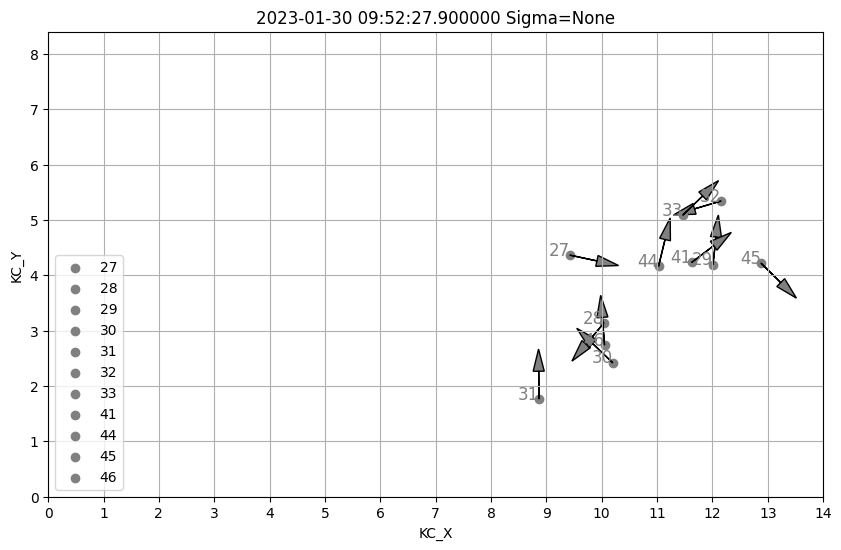

In [21]:
# plot_scene without clustering 
plot_scene(filtered_rows, test_key)

Build the affinity matrix for each scene/timestamp

In [24]:
def affinity_calculation(data_dict, sigma = 1.0, method = 'P', dataset = "starfish"):
    affinity_matrices = {}
    valid_members = {}

    for time, subjects in data_dict.items():
        if dataset == "starfish":
        # Filter out subjects with coordinates [NaN, NaN]
            valid_subjects = {sub_id: coords for sub_id, coords in subjects.items() if not (np.isnan(coords[0]) or np.isnan(coords[1]) or np.isnan(coords[2]))}
            subject_ids = list(valid_subjects.keys())
            coords = np.array(list(valid_subjects.values()))
            positions = coords[:,:2]
            orientations = coords[:,2]
            num_subjects = len(subject_ids)
            valid_members[time] = subject_ids
        elif dataset == "idiap":
            valid_members[time] = subjects
            positions = np.array(subjects)
            num_subjects = len(positions)
            
        else:
            print(f"Doesn't support {dataset}!")
            break
            
        affinity_matrix = np.zeros((num_subjects, num_subjects))
        
        if method == "P":
            for i in range(num_subjects):
                for j in range(num_subjects):
                    # dont set affinity[i][i] to 1, otherwise it would be dominent
                    if i != j:
                        d_ij = np.linalg.norm(positions[i] - positions[j])
                        affinity_matrix[i, j] = np.exp(-d_ij / (2 * sigma**2))
        elif method == "PO":
            for i in range(num_subjects):
                for j in range(num_subjects):
                    if i != j:
                        d_q = np.linalg.norm(positions[i] - positions[j])
                        vector_ij = positions[j] - positions[i]
                        alpha_ij = np.arctan2(vector_ij[1], vector_ij[0])
                        vector_ji = positions[i] - positions[j]
                        alpha_ji = np.arctan2(vector_ji[1], vector_ji[0])
                        
                        theta_i = np.radians(orientations[i])
                        theta_j = np.radians(orientations[j])
                    
                        # Calculate Aori_ij1 and Aori_ij2
                        Aori_ij1 = np.exp(-d_q / (2 * sigma**2)) if -np.pi/2 <= theta_i - alpha_ij <= np.pi/2 else 0
                        Aori_ij2 = np.exp(-d_q / (2 * sigma**2)) if -np.pi/2 <= theta_j - alpha_ji <= np.pi/2 else 0

                        # Final affinity matrix element
                        affinity_matrix[i, j] = min(Aori_ij1, Aori_ij2)
        affinity_matrices[time] = affinity_matrix
    
    return affinity_matrices, valid_members

In [31]:
affinities, members = affinity_calculation(result_dict, sigma = 1.0, method = "P", dataset = "starfish")

In [24]:
result_dict[test_key]

{'27': [9.424099562148742, 4.364549403761846, -12.083535671454996],
 '31': [8.865645837125436, 1.7670263536787305, 90.43432914781545],
 '41': [11.623398636217008, 4.231894387057158, 37.11062225100699],
 '46': [10.050632937596053, 2.7416559053256044, 94.43756480627621],
 '28': [10.040024071693416, 3.1393198900222776, -129.95915901125],
 '32': [12.155697168716824, 5.341548058721754, -163.56567420280703],
 '29': [12.010299382814532, 4.19394252124259, 83.8271428903513],
 '30': [10.198135256767252, 2.419658732175828, 136.16768798455087],
 '33': [11.46395094845645, 5.08570953326632, 44.01380882158492],
 '44': [11.025972988907863, 4.160668924011833, 76.40310721895281],
 '45': [12.877683299226396, 4.21949402808343, -44.645316515252006]}

In [25]:
affinities[test_key], members[test_key]

(array([[0.        , 0.26489054, 0.33232294, 0.41902817, 0.50375472,
         0.23444594, 0.27364859, 0.3511193 , 0.33898869, 0.44601712,
         0.17758351],
        [0.26489054, 0.        , 0.15733522, 0.46433297, 0.40531151,
         0.08811821, 0.13722617, 0.47622474, 0.12155137, 0.1994517 ,
         0.0952625 ],
        [0.33232294, 0.15733522, 0.        , 0.33846706, 0.38217663,
         0.54044616, 0.82334593, 0.31575888, 0.64772576, 0.74020491,
         0.53409958],
        [0.41902817, 0.46433297, 0.33846706, 0.        , 0.81962961,
         0.18775305, 0.29535638, 0.83770697, 0.25446781, 0.42276355,
         0.20290663],
        [0.50375472, 0.40531151, 0.38217663, 0.81962961, 0.        ,
         0.21720464, 0.32713352, 0.69183168, 0.29944657, 0.49174384,
         0.21911745],
        [0.23444594, 0.08811821, 0.54044616, 0.18775305, 0.21720464,
         0.        , 0.56080065, 0.17230071, 0.69158424, 0.44170112,
         0.51317742],
        [0.27364859, 0.13722617, 0.82334

In [26]:
affinities[test_key][1][2]

0.15733522183691317

Perform DS extraction on a random selection of timeframes/all time frames

In [28]:
random.seed(42)
selected_time_keys = random.sample(list(affinities.keys()), 10)
# selected_time_keys =[test_key]
all_time_keys = list(affinities.keys())
interval = 10 # extract per second

fformations = {}

for time_key in selected_time_keys:
    print(time_key)
    matrix = affinities[time_key]
    start_time = datetime.now()
    raw_formations = dominant_sets.dominant_set_extraction(matrix, len(members[time_key]))
    end_time = datetime.now()
    elapsed_time = (end_time - start_time).total_seconds()
    print(f"Time: {time_key}, Elapsed Time: {elapsed_time} seconds")
    print("All members at the scene", members[time_key])
    
    fformations[time_key] = {}
    for i, fformation in enumerate(raw_formations):
        group_members = [members[time_key][j] for j, in_group in enumerate(fformation) if in_group]
        fformations[time_key][i] = group_members
        print(f"Group {i}: {group_members}")
    print("\n")

2023-01-30 10:11:19.300000
Time: 2023-01-30 10:11:19.300000, Elapsed Time: 0.053871 seconds
All members at the scene ['27', '31', '41', '46', '28', '32', '29', '30', '33', '44', '45']
Group 0: ['27', '41', '29', '33', '44']
Group 1: ['46', '28', '30']


2023-01-30 09:52:27.900000
Time: 2023-01-30 09:52:27.900000, Elapsed Time: 0.050253 seconds
All members at the scene ['27', '31', '41', '46', '28', '32', '29', '30', '33', '44', '45']
Group 0: ['41', '32', '29', '33', '44', '45']
Group 1: ['46', '28', '30']


2023-01-30 10:58:05.100000
Time: 2023-01-30 10:58:05.100000, Elapsed Time: 0.009971 seconds
All members at the scene ['27', '31', '41', '46', '28', '32', '29', '30', '33', '44', '45']
Group 0: ['27', '41', '28', '32', '29', '44']


2023-01-30 10:51:30.100000
Time: 2023-01-30 10:51:30.100000, Elapsed Time: 0.011967 seconds
All members at the scene ['27', '31', '41', '46', '28', '32', '29', '30', '33', '44', '45']
Group 0: ['31', '41', '33']
Group 1: ['28', '32', '30']


2023-01-30 1

27 9.424099562148742 4.364549403761846 -12.083535671454996 -0.21089748274907347 0.9778434316954403 -0.20933758164764563
28 10.040024071693416 3.1393198900222776 -129.95915901125 -2.268215217869171 -0.6422414025056773 -0.766502433725778
29 12.010299382814532 4.19394252124259 83.8271428903513 1.463059645976386 0.1075283816799884 0.9942020152530786
30 10.198135256767252 2.419658732175828 136.16768798455087 2.3765744901587342 -0.7213697784695821 0.6925501012278795
31 8.865645837125436 1.7670263536787305 90.43432914781545 1.5783768004616572 -0.007580401066775378 0.9999712683470795
32 12.155697168716824 5.341548058721754 -163.56567420280703 -2.854759558083334 -0.9591446521395924 -0.28291612939530364
33 11.46395094845645 5.08570953326632 44.01380882158492 0.7681858802799822 0.7191723602498643 0.6948317179379762
41 11.623398636217008 4.231894387057158 37.11062225100699 0.6477025457439415 0.7974720844274126 0.6033558440580465
44 11.025972988907863 4.160668924011833 76.40310721895281 1.333485779

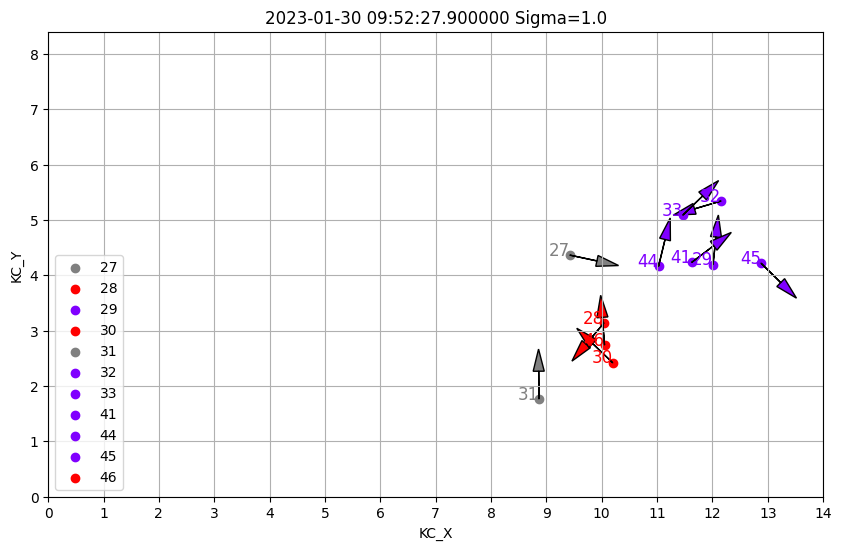

In [29]:
plot_scene(filtered_rows=filtered_rows, time_key=pd.Timestamp("2023-01-30 09:52:27.900000"), sigma=1.0, formations = fformations)

abandoned. Find the group where one pair showing up together the most frequent, the dominent group.

In [31]:
# # fformations is a dictionary where the key is a time_key and the value is another dictionary 
# # with group ID as the key and list of members as the value.

# # Step 1: Encode Unique Group Formations
# group_encoding = {}  # To store unique encoding for each group
# group_id_counter = 0

# for time_key, groups in fformations.items():
#     for group_id, members in groups.items():
#         members_tuple = tuple(sorted(members))  # Use sorted tuple of members to ensure uniqueness
#         if members_tuple not in group_encoding:
#             group_encoding[members_tuple] = group_id_counter
#             group_id_counter += 1

# # Step 2: Count Pairwise Member Appearances in Groups
# pairwise_count = defaultdict(lambda: defaultdict(int))

# for time_key, groups in fformations.items():
#     for group_id, members in groups.items():
#         members_tuple = tuple(sorted(members))
#         encoded_group_id = group_encoding[members_tuple]
#         for i in range(len(members)):
#             for j in range(i + 1, len(members)):
#                 pair = (members[i], members[j])
#                 pairwise_count[pair][encoded_group_id] += 1

# # Step 3: Identify Dominant Group for Each Pair
# dominant_group_for_pair = {}

# for pair, group_counts in pairwise_count.items():
#     dominant_group_id = max(group_counts, key=group_counts.get)
#     dominant_group_for_pair[pair] = dominant_group_id

# # Output the dominant groups for each member pair
# for pair, group_id in dominant_group_for_pair.items():
#     original_group = [k for k, v in group_encoding.items() if v == group_id][0]
#     print(f"Member Pair {pair}: Dominant Group Encoding {group_id}, Members in Dominant Group: {original_group}")


Member Pair ('29', '44'): Dominant Group Encoding 2, Members in Dominant Group: ('29', '32', '33', '41', '44', '45')
Member Pair ('29', '33'): Dominant Group Encoding 2, Members in Dominant Group: ('29', '32', '33', '41', '44', '45')
Member Pair ('29', '27'): Dominant Group Encoding 0, Members in Dominant Group: ('27', '29', '33', '41', '44')
Member Pair ('29', '41'): Dominant Group Encoding 2, Members in Dominant Group: ('29', '32', '33', '41', '44', '45')
Member Pair ('44', '33'): Dominant Group Encoding 2, Members in Dominant Group: ('29', '32', '33', '41', '44', '45')
Member Pair ('44', '27'): Dominant Group Encoding 0, Members in Dominant Group: ('27', '29', '33', '41', '44')
Member Pair ('44', '41'): Dominant Group Encoding 2, Members in Dominant Group: ('29', '32', '33', '41', '44', '45')
Member Pair ('33', '27'): Dominant Group Encoding 0, Members in Dominant Group: ('27', '29', '33', '41', '44')
Member Pair ('33', '41'): Dominant Group Encoding 2, Members in Dominant Group: ('

In [32]:
# # Load the CSV file into a DataFrame
# csv_file = 'social_contact_ratios_with_diagnosis_half.csv'
# sc_half_df = pd.read_csv(csv_file)

# # Assuming 'dominant_group_for_pair' is already created as a dictionary from previous code
# # where keys are tuples of member pairs and values are the corresponding dominant group encodings

# # Define a function to find the dominant group for a pair
# def find_dominant_group(subject, partner):
#     subject = str(subject)
#     partner = str(partner)
#     pair = (subject, partner) if (subject, partner) in dominant_group_for_pair else (partner, subject)
#     return dominant_group_for_pair.get(pair, "No dominant group")

# # Apply the function to each row in the DataFrame
# sc_half_df['Group'] = sc_half_df.apply(lambda row: find_dominant_group(row['Subject'], row['Partner']), axis=1)

# # Save the updated DataFrame to a new CSV file
# output_file = 'social_contact_ratios_with_diagnosis_half_with_groups.csv'
# sc_half_df.to_csv(output_file, index=False)

# print(f"Updated CSV saved to {output_file}")

Updated CSV saved to social_contact_ratios_with_diagnosis_half_with_groups.csv


{Timestamp('2023-01-30 10:17:29'): array([[0.00000000e+000, 1.07863876e-026, 1.37968400e-029,
        0.00000000e+000, 0.00000000e+000, 1.14455770e-032,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [1.07863876e-026, 0.00000000e+000, 9.23256637e-049,
        9.23020589e-063, 8.02646925e-054, 0.00000000e+000,
        0.00000000e+000, 8.46974471e-073, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [1.37968400e-029, 9.23256637e-049, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 9.44471519e-057,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 9.23020589e-063, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 1.03295882e-066,
        0.00000000e+000, 0.00000000e+000, 2.92832464e-103,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 8.02646925e-054, 0.00000000e+000,
        0.00000000e+000, 0

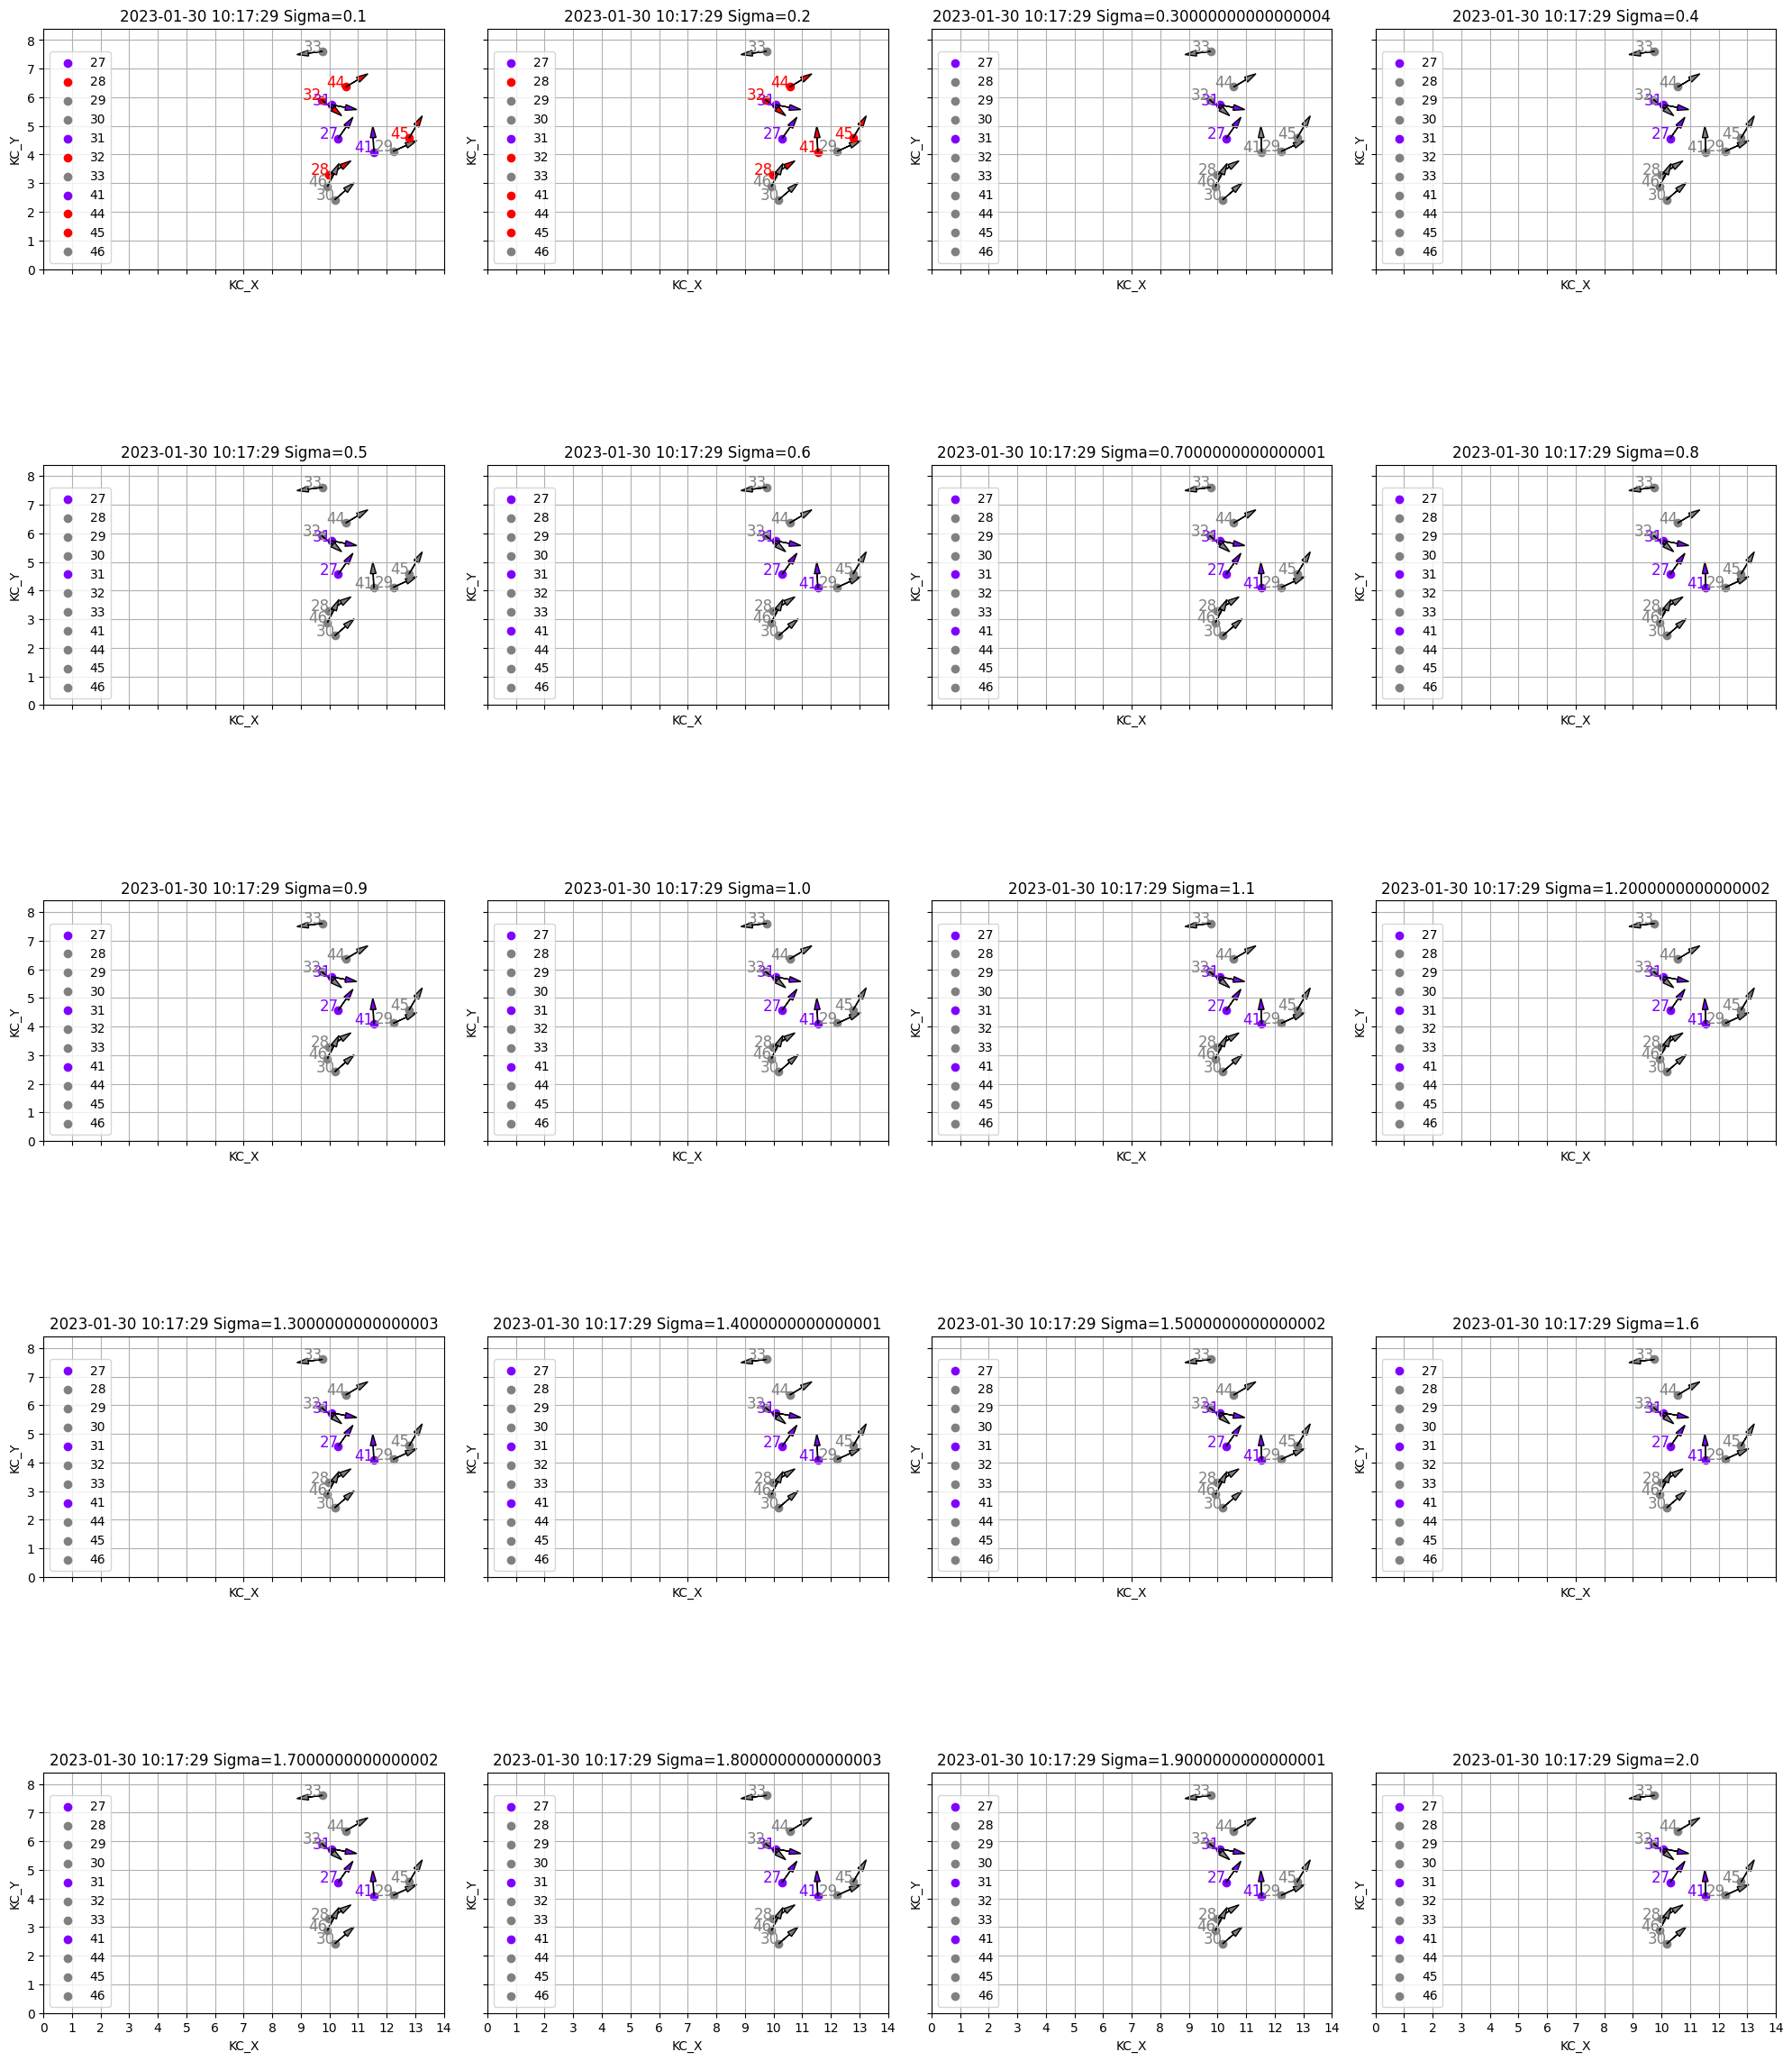

In [30]:
# Plotting for different sigma values
sigma_values = np.arange(0.1, 2.1, 0.1)
num_sigma = len(sigma_values)
fig, axes = plt.subplots(5, 4, figsize=(20, 25), sharex=True, sharey=True)

t = pd.Timestamp('2023-01-30 10:17:29')
# t = test_key
scene = {t: result_dict[t]}

for ax, sigma in zip(axes.flatten(), sigma_values):
    a, m = affinity_calculation(scene, sigma=sigma, method="PO")
    print(a)
    raw_fs = dominant_sets.dominant_set_extraction(a[t], len(m[t]))
    fs = {t: {}}
    print(f"Sigma = {sigma}")
    for i, f in enumerate(raw_fs):
        group_members = [m[t][j] for j, in_group in enumerate(f) if in_group]
        fs[t][i] = group_members
        print(f"Group {i}: {group_members}")
    plot_scene(formations= fs, filtered_rows = filtered_rows, time_key= t, ax=ax, sigma=sigma,)

plt.tight_layout()
plt.show()

Compare with kmeans grouping method

In [ ]:
from sklearn.cluster import KMeans

In [ ]:

coord_columns = [col for col in pivot_df.columns if '_KC_X' in col or '_KC_Y' in col]

members_in_a_scene = {}
groups_detected = {}

step_size = 600

# Group by TIME and apply K-means clustering
for i in range(0, len(pivot_df), step_size):
    group = pivot_df.iloc[i]
    # Extract coordinate data for the current time frame
    coord_data = group[coord_columns]
    time = group['TIME']
    
    # Handle missing values by dropping rows with NaN values
    coord_data_cleaned = coord_data.dropna()
    
    coord_data_cleaned = np.array(coord_data_cleaned).reshape([-1,2])
    
    if coord_data_cleaned.shape[0] > 2:  # Ensure there's data to cluster
        k = 3  # Example number of clusters; you should choose based on your needs
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(coord_data_cleaned)
        
        # Assign cluster labels to the current group
        cluster_labels = kmeans.labels_
        
    member_ids = [col.split('_')[0] for col in coord_columns[::2]]
    members_in_a_scene[time] =  member_ids
    
    clusters = {}
    for label, member_id in zip(cluster_labels, member_ids):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(member_id)      
    groups_detected[time] = clusters

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

In [ ]:
groups_detected

{Timestamp('2023-01-30 09:47:00.100000'): {1: ['27', '28'],
  0: ['29', '32', '33', '41', '44'],
  2: ['30', '31', '45']},
 Timestamp('2023-01-30 09:48:00.100000'): {0: ['27', '29', '32', '33', '44'],
  2: ['28', '41'],
  1: ['30', '31', '45']},
 Timestamp('2023-01-30 09:49:00.100000'): {0: ['27',
   '29',
   '32',
   '33',
   '41',
   '45'],
  1: ['28', '30', '31', '46'],
  2: ['44']},
 Timestamp('2023-01-30 09:50:00.100000'): {0: ['27', '31', '33'],
  2: ['28', '30', '46'],
  1: ['29', '32', '41', '44', '45']},
 Timestamp('2023-01-30 09:51:00.100000'): {0: ['27', '33', '44'],
  1: ['28', '30', '31', '46'],
  2: ['29', '32', '41', '45']},
 Timestamp('2023-01-30 09:52:00.100000'): {0: ['27', '33', '41', '44'],
  1: ['28', '30', '31', '46'],
  2: ['29', '32', '45']},
 Timestamp('2023-01-30 09:53:00.100000'): {0: ['27', '44'],
  1: ['28', '30', '31', '46'],
  2: ['29', '32', '33', '41', '45']},
 Timestamp('2023-01-30 09:54:00.100000'): {0: ['27', '33'],
  2: ['28', '30', '31', '44', '46'